# DS 7333 - Quantifying the World
## Case Study #6: "Searching for Exotic Particles in High-Energy Physics with Deep Learning"¶

Sterling Beason, Sean Kennedy, Emil Ramos

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display
%matplotlib inline
# modeling
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
# sklearn helpers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [31]:
print(tf.__version__)

2.2.0


In [113]:
def do_model(name,
             features,
             labels,
             base_activation='tanh',
             epochs=200,
             batch_size=100,
             decay_rate=0.5,
             optimizer=None):
    display(md(f"### {name}"))

    initial_learning_rate = 0.05
    if not optimizer:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=100000,
            decay_rate=decay_rate,
            staircase=True)
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    # Partition data
    display(md("#### Partition Data"))
    X = features
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.20,
                                                        random_state=7333)
    print("done.")

    # Partition data
    display(md("#### Normalize Data"))
    
    #fit to train data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #transform test, do not fit
    X_test = scaler.transform(X_test)

    print("done.")

    
    # Build model
    display(md("#### Build Model"))
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(300, activation=base_activation),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    print("done.")

    # early stopping callback
    es = EarlyStopping(monitor="accuracy", min_delta=0.01, patience=4)

    display(md("#### Train Model"))
    # fit
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        callbacks=[es],
                        epochs=epochs,
                        batch_size=batch_size)

    display(md("#### Train/Loss Plot (MSE)"))

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    ax.ravel()
    #print(history.history)
    p = sns.lineplot(x=range(1,
                             len(history.history['loss']) + 1),
                     y=history.history['loss'],
                     color='blue',
                     label='train',
                     ax=ax[0])
    sns.lineplot(x=range(1,
                         len(history.history['val_loss']) + 1),
                 y=history.history['val_loss'],
                 color='orange',
                 label='validation',
                 ax=ax[0])
    p.set_ylabel('Loss (Blue: Train, Orange: Val.)')
    p.set_xlabel('Epochs')
    p.set_title('Training/Validation Curves')

    # accuracy
    model_scores = model.evaluate(X_test, y_test, verbose=0)

    # AUC
    predictions = model.predict(X_test).ravel()  # predictions
    fpr, tpr, thresholds = roc_curve(y_test, predictions)  # ROC
    auc_metric = auc(fpr, tpr)  # finally AUC

    # print metrics
    display(md("#### Evaluate Model - Metrics"))
    print('Accuracy:', model_scores[1])
    print(f"AUC: {auc_metric}")
    print(f"base_activation: {base_activation}")

    #ROC curve
    p = sns.scatterplot(
        x=fpr,
        y=tpr,
        label=f'Keras NN {base_activation}: AUC {round(auc_metric, 3)}',
        ax=ax[1],
        ci=None)
    p.set_title('ROC Curve')
    plt.show()
    display(md(f"### ----------------------------------"))

    return (model_scores[1], auc_metric)

In [99]:
print([x for x in range(1, 2)])

[1]


### Import Data

Subset to 3,000,000 rows so as to conserve training time

In [80]:
# import data
nrows = 3000000
data = pd.read_csv("./data/HIGGS.csv", nrows=nrows, header=None)
data[0] = data[0].astype(int)
print(f"Using {nrows:,.0f} rows of entire dataset")

Using 3,000,000 rows of entire dataset


### Data Description 


> The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features): lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb. For more detailed information about each feature see the original paper.



### Partition Data

- Low-level features

- High-level features

- All features

***We're running all three - why not? :)***

***The train test split will be 80/20 train/test*** 

### Your replica neural network based on the paper’s architecture


***Theirs***

**https://arxiv.org/pdf/1402.4735.pdf** 

(pg. 6)
>We selected a five-layer neural
network with 300 hidden units in each layer, a learning
rate of 0.05, and a weight decay coefficient of 1 × 10−5.

(pg. 9, Methods)
>Hidden units all used the tanh activation function.
Weights were initialized from a normal distribution with
zero mean and standard deviation 0.1 in the first layer,
0.001 in the output layer, and 0.05 all other hidden layers

(pg. 9, Methods)
>  Gradient computations were made on mini-batches
of size 100. A momentum term increased linearly over
the first 200 epochs from 0.9 to 0.99, at which point it
remained constant.

(pg. 9, Methods)
>Training ended when the momentum had
reached its maximum value and the minimum error on
the validation set (500,000 examples) had not decreased
by more than a factor of 0.00001 over 10 epochs. This
early stopping prevented overfitting and resulted in each
neural network being trained for 200-1000 epochs.

(pg. 9, Methods)
>Autoencoder pretraining was performed by training a
stack of single-hidden-layer autoencoder networks as in
[9], then fine-tuning the full network using the class labels. Each autoencoder in the stack used tanh hidden
units and linear outputs, and was trained with the same
initialization scheme, learning algorithm, and stopping
parameters as in the fine-tuning stage. When training
with dropout, we increased the learning rate decay factor
to 1.0000003, and only ended training when the momentum had reached its maximum value and the error on the
validation set had not decreased for 40 epochs.


**Ours**

In this approach, we will model as closely as possible with the following models/parameters.

- Keras Sequential NN
- Keras Optimizers (controls learning decay rate in our Stochastic Gradient Descent algorithm) 

The exponential decay of the learning rate at step n of the SGD search is controlled by the function:

$$lr_{n}=lr_{0}*d^\frac{n}{ds}$$


Where $lr_{n}$ is the learning rate at step $n$, $lr_{0}$ is the initial learning rate, $d$ is the decay rate and $ds$ is the number of steps where the decay will be applied. This method is slightly different than that used by the researchers (see notes in summary/conclusion)


We will match the inital learning rate $lr_{0}=0.05$.

We will be setting the learning rate decay steps ($ds$) = 10,000. Setting our decay rate to 0.50 gives us an effective learning rate curve that looks like the below:


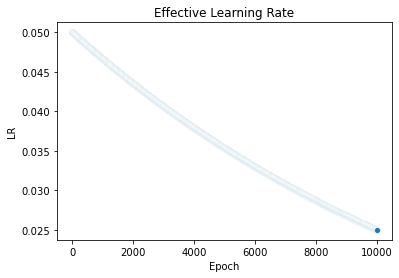

In [112]:
iters = 10000
epochs = range(1, iters + 1)
learning_rate = 0.05
decay_rate = 0.50
effective_learning_rate = [learning_rate*decay_rate**(n/iters) for n in epochs]
p = sns.scatterplot(x=epochs, y=effective_learning_rate, ci=None)
p.set_title('Effective Learning Rate')
p.set_xlabel('Epoch')
p.set_ylabel('LR')
p

Ideally, this will allow our network to converge more quickly than it would otherwise. 

The researchers were able to set the initial weights of their layers according to specified normal ($N(\mu,\sigma$)) distributions - keras dense layers do not seem to support that option out of the box so we will proceed with the default keras implementation which is random initialization. 

Our model will consist of:

- an implicit input layer (matching the dimensions of our feature set) 
- 4, 300 node dense tanh activation layers
- 1 50% probability drop out layer between the 1st and second dense layer
- 1 final layer with single node (sigmoid activation)

The drop out layer will serve as a regularization layer.

Our stopping method will be accuracy based with a min delta of 0.01 and patience setting of 4. This will truncate training when an increase of 0.01 in accuracy is not achieved over the course of 4 epochs.

The researchers were also able to use a paramter called **momentum** in their stopping algorithm which was not available to us in the keras api.

Note that all of our inputs were scaled to $N(0,1)$ using the sk-learn StandardScaler

### Low-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 88s 4ms/step - loss: 0.2343 - accuracy: 0.5976 - val_loss: 0.2197 - val_accuracy: 0.6435
Epoch 2/200
24000/24000 [==============================] - 88s 4ms/step - loss: 0.2188 - accuracy: 0.6451 - val_loss: 0.2116 - val_accuracy: 0.6633
Epoch 3/200
24000/24000 [==============================] - 86s 4ms/step - loss: 0.2132 - accuracy: 0.6593 - val_loss: 0.2072 - val_accuracy: 0.6737
Epoch 4/200
24000/24000 [==============================] - 86s 4ms/step - loss: 0.2102 - accuracy: 0.6665 - val_loss: 0.2049 - val_accuracy: 0.6790
Epoch 5/200
24000/24000 [==============================] - 87s 4ms/step - loss: 0.2079 - accuracy: 0.6716 - val_loss: 0.2020 - val_accuracy: 0.6853
Epoch 6/200
24000/24000 [==============================] - 87s 4ms/step - loss: 0.2068 - accuracy: 0.6740 - val_loss: 0.2013 - val_accuracy: 0.6870
Epoch 7/200
24000/24000 [==============================] - 87s 4ms/step - loss: 0.2061 - accuracy: 0.6760 - val_

#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.690351665019989
AUC: 0.7562998028902375
base_activation: tanh


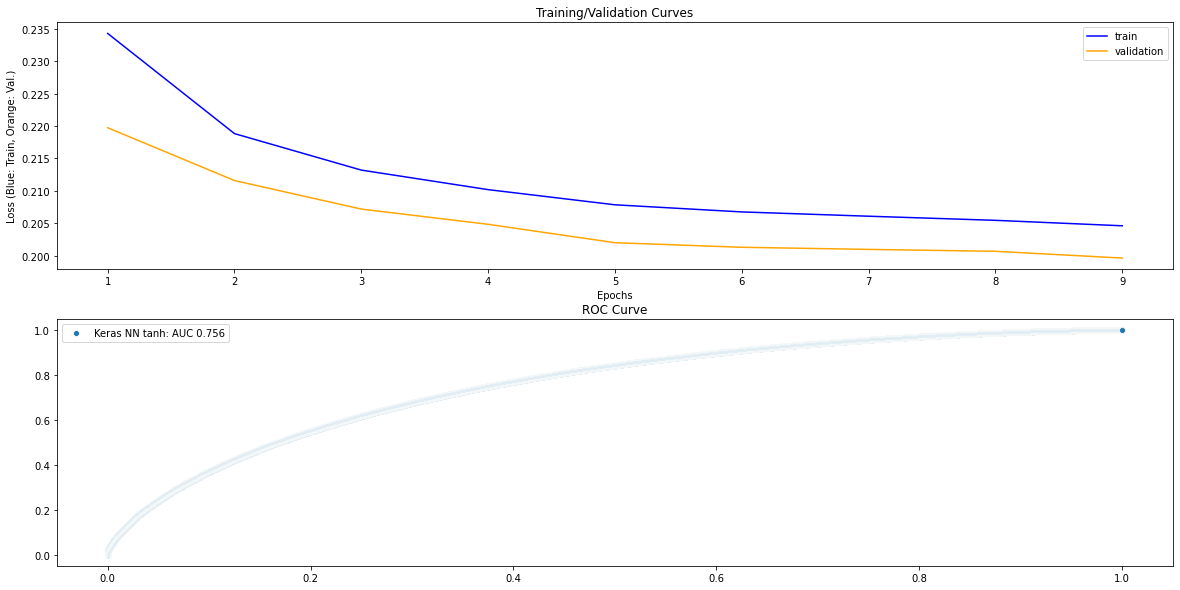

### ----------------------------------

### High-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 88s 4ms/step - loss: 0.2062 - accuracy: 0.6735 - val_loss: 0.1919 - val_accuracy: 0.7016
Epoch 2/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1933 - accuracy: 0.6987 - val_loss: 0.1893 - val_accuracy: 0.7057
Epoch 3/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1912 - accuracy: 0.7022 - val_loss: 0.1879 - val_accuracy: 0.7081
Epoch 4/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1902 - accuracy: 0.7039 - val_loss: 0.1871 - val_accuracy: 0.7097
Epoch 5/200
24000/24000 [==============================] - 86s 4ms/step - loss: 0.1893 - accuracy: 0.7060 - val_loss: 0.1866 - val_accuracy: 0.7101
Epoch 6/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1889 - accuracy: 0.7065 - val_loss: 0.1862 - val_accuracy: 0.7114


#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.7114149928092957
AUC: 0.7896993584627365
base_activation: tanh


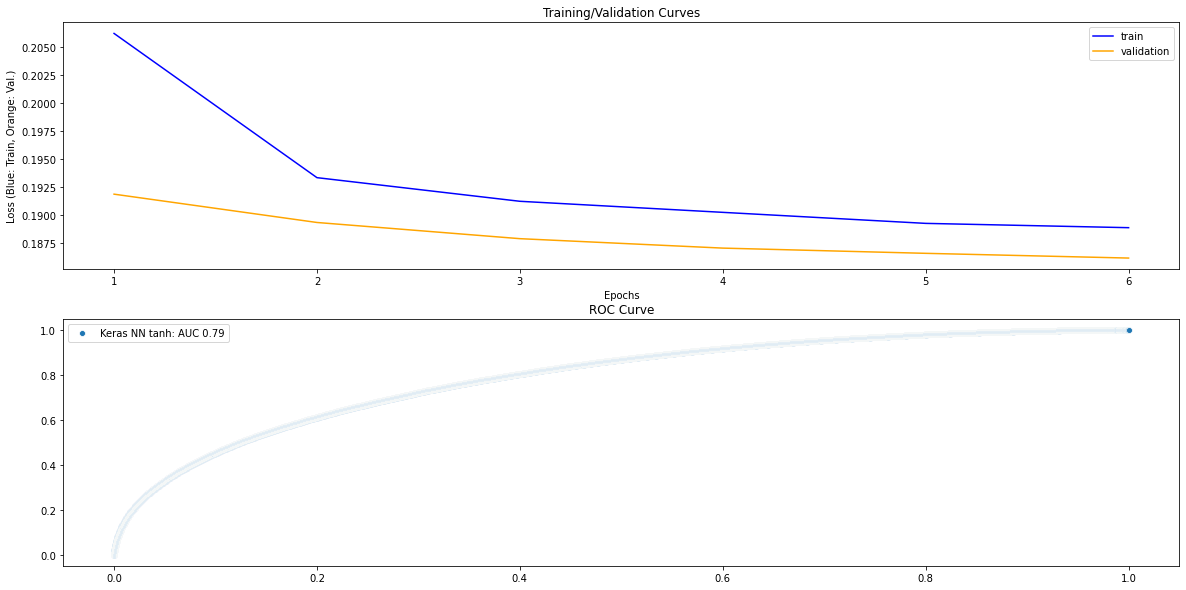

### ----------------------------------

### Mix-Low+High

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.2101 - accuracy: 0.6666 - val_loss: 0.1871 - val_accuracy: 0.7146
Epoch 2/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1869 - accuracy: 0.7148 - val_loss: 0.1770 - val_accuracy: 0.7327
Epoch 3/200
24000/24000 [==============================] - 86s 4ms/step - loss: 0.1801 - accuracy: 0.7272 - val_loss: 0.1738 - val_accuracy: 0.7384
Epoch 4/200
24000/24000 [==============================] - 86s 4ms/step - loss: 0.1774 - accuracy: 0.7319 - val_loss: 0.1709 - val_accuracy: 0.7429
Epoch 5/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1751 - accuracy: 0.7360 - val_loss: 0.1697 - val_accuracy: 0.7450
Epoch 6/200
24000/24000 [==============================] - 85s 4ms/step - loss: 0.1741 - accuracy: 0.7374 - val_loss: 0.1693 - val_accuracy: 0.7455
Epoch 7/200
24000/24000 [==============================] - 86s 4ms/step - loss: 0.1735 - accuracy: 0.7386 - val_

#### Train/Loss Plot (MSE)

#### Evaluate Model - Metrics

Accuracy: 0.7496349811553955
AUC: 0.8313661153788147
base_activation: tanh


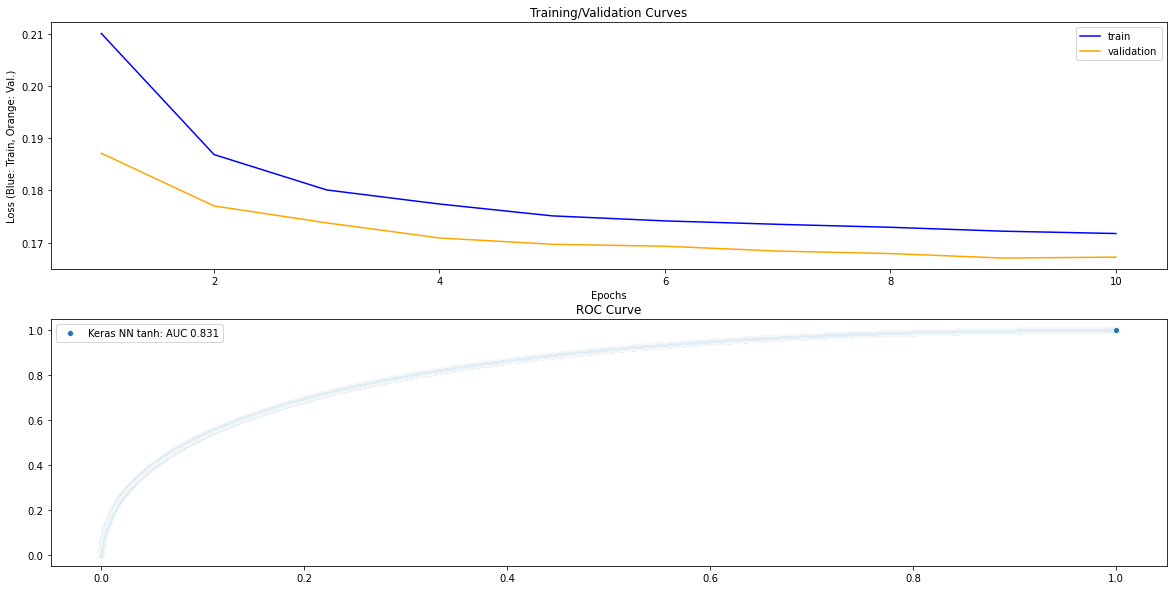

### ----------------------------------

In [114]:
%matplotlib inline

compare_dict = {}

compare_dict["Low-level"] = do_model("Low-level",
                                     data.iloc[:, range(1, 22)].values,
                                     data[0].values)
compare_dict["High-level"] = do_model("High-level",
                                     data.iloc[:, range(22, 29)].values,
                                     data[0].values)
compare_dict["Mix-Low+High"] = do_model("Mix-Low+High",
                                     data.iloc[:, range(1, 29)].values,
                                     data[0].values)

In [ ]:
%matplotlib inline



compare_dict["Low-level relu"] = do_model("Low-level",
                                     data.iloc[:, range(1, 22)].values,
                                     data[0].values,
                                     base_activation='relu')
compare_dict["High-level relu"] = do_model("High-level",
                                     data.iloc[:, range(22, 29)].values,
                                     data[0].values,
                                     base_activation='relu')
compare_dict["Mix-Low+High relu"] = do_model("Mix-Low+High",
                                     data.iloc[:, range(1, 29)].values,
                                     data[0].values,
                                     base_activation='relu')

### Low-level

#### Partition Data

done.


#### Normalize Data

done.


#### Build Model

done.


#### Train Model

Epoch 1/200
24000/24000 [==============================] - 87s 4ms/step - loss: 0.2315 - accuracy: 0.6072 - val_loss: 0.2208 - val_accuracy: 0.6408
Epoch 2/200
24000/24000 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.6380

***Any recommendations or modifications you’d make to the approach taken by the researchers (i.e., state any proposed changes along with the expected improvements or impact)***

(page 9)
>In training the neural networks, the following hyperparameters were predetermined without optimization

[Keras classifiers can now be used with the same cross validation/grid search architecture found in sk-learn](https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f). Using that type of hyperparameter tuning could have been incredibly helpful had it been available to the researchers in this paper. Varying dropout rates, learning rates, weight decay, activation functions and network geometry (layers/depth) could have allowed them to search a much larger parameter space in an efficient way.

The researchers were also seemingly limited by the lack of cheap compute we currently enjoy today. The dataset used in their hyper parameter search (2.6mm training observations, 100k validation records) could have been expanded greatly given the increased availability of GPUs or perhaps even TPUs. Even with our unremarkable PC hardware, we were easily able to use 3 million rows of data in our analysis.

Additionally, many of the Keras optimization options were not available to the researchers. Classes such as [exponential_decay](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) could have saved them time due to the ease of use versus pylearn2. With that said, their "hands on" approach to learning rate decay allowed them more control over the overall decay process. Simply using the keras optimizers did not allow us to set sophisticated stopping criterion for the decay as the researchers did in their algorithm.

Additionally, while they mentioned adding a dropout layer for regularization/better generalization, they did not seem to implement this layer in their [code](https://github.com/uci-igb/higgs-susy/blob/master/higgs/layers4_width300_lr005_m200_wd000001_all.py) This was trivial using the keras framework.


***What are standard practices now versus when this paper was written?***  

Nearly all activation layers in modern NN architechture make use of sigmoid or relu functions instead of tanh due to the simplicity of the derivatives for sigmoid and relu. This typically decreases training time. In our case, we decided to run the exact same NN with relu instead of tanh and while we did not notice a speed increase for training time, we did see better results for accuracy and AUC with the relu activation. 

The researchers also made an odd choice with the initialization of the weights in their hidden layers - opting for a varying scheme of samples taken from normal distributions by layer. Best practices usually dicate the use of random initialization of weights. It's unclear why they chose this route or what benefit it may have provided, if any.

Pylearn2 is [dead](https://github.com/lisa-lab/pylearn2) - no one would use that particular library these days. There is no active support. Keras/tensorflow or sk-learn are the (current) gold standards for machine learning in python.

***How would you quantify if your result duplicated the paper’s (hint: what evaluation metric did the researchers use)?***

We were able to closely mirror the AUC scores achieved by the DNN approach taken by the researchers. Using the tanh activation function:

|||Low Level ||High Level ||All|
|--||----------||----------||----------|
|Theirs|| 0.88||0.80||0.80|
|Ours|| 0.76|| 0.79|| 0.83|

Using the relu activation function:

|Low Level ||High Level ||All|
|----------||----------||----------|
| 0.88||0.75||0.75|

A closer comparison of the models could be undertaken by comparing the weights in the network, but that would require us to fully implement the model on the researchers github which was beyond the scope of this analysis. 

All in all, we were able to closely replicate the results using far fewer lines of coding and in a much more efficient manner given the architecture and hardware improvements that have been made since the papers publication. The relative ease in creating a neural network using modern software architecture does come at a price - overall, the researchers were able to get very good results using the older architecture. This is probably due to the granular level of control the researchers exerted over the algorithm by using a much lower level API (which is unfortunately deprecated).
